# Event finder & raw data checker

This notebook will find competitive cellular "events" in the simplest definition (i.e. a loser cell apoptosis) and return information about the spatiotemporal distrubition of counterpart competitive events (i.e. winner cell mitosis)

Contents:

- Load modules
- Load cell finding functions
- Set experiment data path
- Load image data
- Load tracking data
- Apply necessary coordinate shift for viewer
- Isolate one track of interest (target track)
- Find corresponding tracks/events of interest within a given spatiotemporal range (E.g. if target track is Scr apoptosis, then find all nearby wild-type mitosis)
- Set points and regions of interest for highlighting in Napari viewer(now set as functions so this bit is automatic
- Launch Napari image viewer if desired

To-do:

- [x] Reorganise structure so that scan over all R then filter
- [x] Create radial bins and sort tracks into them
- [x] Create temporal bins
- [x] Figure out how to plot said bins into heat map image
- [ ] Check redesigned script against raw data 

In [1]:
import napari
import btrack
import numpy as np
from skimage.io import imread
import os
print("Napari version no.:", napari.__version__)
print("btrack version no.:", btrack.__version__)
from btrack.utils import import_HDF, import_JSON, tracks_to_napari
from tqdm.notebook import tnrange, tqdm
import matplotlib.pyplot as plt

Napari version no.: 0.4.0
btrack version no.: 0.4.0


### Functions to measure local neighbourhood for cells of interest

In [2]:
def euclidean_distance(target_track, other_track, frame):
    try:
        idx0 = target_track.t.index(find_apoptosis_time(target_track, index = False)) ## could also do just ## apop_index
        idx1 = other_track.t.index(frame)
    except:
        return np.inf
    
    dx = target_track.x[idx0] - other_track.x[idx1]
    dy = target_track.y[idx0] - other_track.y[idx1]
    dt = target_track.t[idx0] - other_track.t[idx1]
    
    return np.sqrt(dx**2 + dy**2) #, dt

def find_apoptosis_time(target_track, index): ### if index is set to True then the index of the apoptotic time (wrt target_track) is returned
    for i, j in enumerate(target_track.label):
        if j == 'APOPTOSIS' and target_track.label[i+1] == 'APOPTOSIS' and target_track.label[i+2] == 'APOPTOSIS': # and target_track.label[i+3] =='APOPTOSIS' and target_track.label[i+4] =='APOPTOSIS':
            apop_index = i
            break
    apop_time = target_track.t[apop_index]
    if index == True: 
        return apop_index
    else: 
        return apop_time

def find_nearby_wt_mitosis(target_track, delta_t, radius):
    frame = find_apoptosis_time(target_track, index = False) + delta_t 
    dividing_states = ('METAPHASE',) #('PROMETAPHASE', 'METAPHASE', 'DIVIDE')
    wt_tracks_in_radius = [wt_track for wt_track in wt_tracks if wt_track.in_frame(frame) if euclidean_distance(target_track, wt_track, frame)<radius]
    wt_mitosis_in_radius = [wt_track for wt_track in wt_tracks if wt_track.in_frame(frame) if euclidean_distance(target_track, wt_track, frame)<radius if wt_track.label[wt_track.t.index(frame)] in dividing_states if wt_track.fate.name == "DIVIDE"] ###check this
  
    return wt_tracks_in_radius, wt_mitosis_in_radius


def maximum_xyt(i):
    #### BEWARE xy coord switch!     
    if i == 'x':
        max_x = int((max([max(i.y) for i in wt_tracks])))
        return max_x
    if i == 'y':
        max_y = int((max([max(i.x) for i in wt_tracks])))
        return max_y
    if i == 't':
        max_t = int((max([max(i.t) for i in wt_tracks])))
        return max_t
    
def plot_mitoses(): ## this function plots mitosis events into the napari viewer
    apop_event = target_track.t[apop_index], target_track.x[apop_index]+shift_y, target_track.y[apop_index]+shift_x ## with transposed shift
    t_m, x_m, y_m = np.zeros(len(wt_mitosis_in_radius)), np.zeros(len(wt_mitosis_in_radius)), np.zeros(len(wt_mitosis_in_radius))
    mito_events = np.zeros((len(wt_mitosis_in_radius), 3)) ## 3 because of the 3 cartesian coords 
    for i, wt_mitosis in enumerate(wt_mitosis_in_radius): ## this now assumes that the mitosis time point of relevance isnt the last frame of track but the time at delta_t, need to bolster definition of mitosis
        mito_index = [j for j, k in enumerate(wt_mitosis.t) if k == apop_event[0]+delta_t][0] ### [0] bc first item of list comprehension
        t_m[i], x_m[i], y_m[i] = wt_mitosis.t[mito_index], wt_mitosis.x[mito_index]+shift_y, wt_mitosis.y[mito_index]+shift_x ## plus transposed coordinate shift
        mito_events[i] = t_m[i], x_m[i], y_m[i]
    return viewer.add_points(mito_events, name = "Mitosis events", symbol = "cross", face_color = 'pink')

def plot_apoptosis(): ## this function plots apoptotic event and surrounding local environment scope (determined by radius)
    ### add_points needs to be txy
    apop_event = target_track.t[apop_index], target_track.x[apop_index]+shift_y, target_track.y[apop_index]+shift_x ## with transposed shift
    ## apop_circle is the bounding box of the ellipse highlighting radial extent around apoptosis, shown at the shifted time and apop time
    apop_circle = [((apop_event[0]+delta_t, apop_event[1]-radius, apop_event[2]-radius), 
                    (apop_event[0]+delta_t, apop_event[1]+radius, apop_event[2]-radius), 
                    (apop_event[0]+delta_t, apop_event[1]+radius, apop_event[2]+radius), 
                    (apop_event[0]+delta_t, apop_event[1]-radius, apop_event[2]+radius)), 
                    ((apop_event[0], apop_event[1]-radius, apop_event[2]-radius), 
                    (apop_event[0], apop_event[1]+radius, apop_event[2]-radius), 
                    (apop_event[0], apop_event[1]+radius, apop_event[2]+radius), 
                    (apop_event[0], apop_event[1]-radius, apop_event[2]+radius))]
    
    return viewer.add_points(apop_event, name = "Apoptosis event", symbol = 'x', face_color = "c"), viewer.add_shapes(apop_circle, opacity = 0.1, shape_type = 'ellipse', face_color = 'y', name = 'Radial environment')
    


### Set experiment data path 

In [3]:
# print("Input experiment number")
# experiment_no = input()
# root_path = os.path.join('/home/nathan/data/kraken/h2b/giulia/', experiment_no)
root_path = '/home/nathan/data/kraken/h2b/giulia/GV0807'  ## this overwrites input option for ease 
gfp_path = os.path.join(root_path, 'Pos3/stacks/gfp.tif')
rfp_path = os.path.join(root_path, 'Pos3/stacks/rfp.tif')
bf_path = os.path.join(root_path, 'Pos3/stacks/bf.tif')
tracks_path = os.path.join(root_path, 'Pos3/Pos3_aligned/HDF/segmented.hdf5')

### Load image data

In [4]:
gfp = imread(gfp_path) ## gfp image data needed to load tracking data (alignment)

In [ ]:
rfp = imread(rfp_path)

In [ ]:
#bf = imread(bf_path) #3 large 1000+ frame stacks is usually too much for memory to process on 16gb ram

### Load tracking data

In [5]:
with btrack.dataio.HDF5FileHandler(tracks_path, 'r', obj_type = "obj_type_1") as hdf:
    wt_tracks = hdf.tracks
with btrack.dataio.HDF5FileHandler(tracks_path, 'r', obj_type = "obj_type_2") as hdf:
    scr_tracks = hdf.tracks
print("Tracks loaded")


[INFO][2021/01/02 05:25:45 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/01/02 05:25:45 PM] Loading tracks/obj_type_1
[INFO][2021/01/02 05:25:50 PM] Loading objects/obj_type_1 (408973, 5) (388394 filtered: area>=100)
[INFO][2021/01/02 05:25:55 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2021/01/02 05:25:55 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/01/02 05:25:55 PM] Loading tracks/obj_type_2
[INFO][2021/01/02 05:25:55 PM] Loading objects/obj_type_2 (12115, 5) (8894 filtered: area>=100)
[INFO][2021/01/02 05:25:55 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5


Tracks loaded


In [ ]:

### finding coord range of aligned images, coords switched already
align_x_range, align_y_range = gfp.shape[2], gfp.shape[1]
### finding maximum extent of tracking coords
tracks_x_range = round(max([max(track.x) for track in wt_tracks]))
tracks_y_range = round(max([max(track.y) for track in wt_tracks])) + 2 ## sort this lazy hack out later

### coord switch
tmp = tracks_y_range
tracks_y_range = tracks_x_range
tracks_x_range = tmp

print("tracks range:", (tracks_x_range), (tracks_y_range))
print("aligned image range:", (align_x_range), (align_y_range))

shift_x = int((align_x_range - tracks_x_range)/2)
shift_y = int((align_y_range - tracks_y_range)/2)

print("shift in x and y:", shift_x, shift_y)

wt_data, properties, graph = tracks_to_napari(wt_tracks, ndim = 2)
scr_data, properties, graph = tracks_to_napari(scr_tracks, ndim = 2)

tmp = wt_data[:,2].copy() ## copy the true_y coord
wt_data[:,2] = wt_data[:,3]  ##assign the old_y coord as the true_x
wt_data[:,3] = tmp ## assign the old_x as true_y

wt_data[:,2] += shift_y ## TRUE_Y (vertical axis)
wt_data[:,3] += shift_x ## TRUE_X (horizontal axis)

tmp = scr_data[:,2].copy()
scr_data[:,2] = scr_data[:,3]
scr_data[:,3] = tmp

scr_data[:,2] += shift_y ## TRUE_Y (vertical axis)
scr_data[:,3] += shift_x ## TRUE_X (horizontal axis)

print("coordinate shift applied")

### Isolate one track of interest

In [7]:
## isolate one target scribble track of interest
print("input scribble track of interest ID")
cell_ID = int(input())
index = [i for i, scr_tracks in enumerate(scr_tracks) if scr_tracks.ID == cell_ID][0]
target_track = scr_tracks[index]##### Show the first classification of each track
apop_index, apop_time = find_apoptosis_time(target_track, index = True), find_apoptosis_time(target_track, index = False)  

input scribble track of interest ID
17


In [25]:
### isolate other wt cell of interest
cell_ID = 218
index = [i for i, wt_tracks in enumerate(wt_tracks) if wt_tracks.ID == cell_ID][0]
other_target_track = wt_tracks[index]

# Find cells of interest

In [8]:
radius = 500
delta_t = 0
wt_tracks_in_radius, wt_mitosis_in_radius = find_nearby_wt_mitosis(target_track, delta_t, radius)
## display ID for all tracks found in radius 
print("ID for all tracks in radius:", [j.ID for i, j in enumerate(wt_tracks_in_radius)])
print("ID for all mitoses in radius:", [j.ID for i, j in enumerate(wt_mitosis_in_radius)])

ID for all tracks in radius: [42, 4, 94, 109, 143, 169, 189, 218, 311, 330, 340, 346, 344, 380, 381, 405, 420, 421, 437, 436, 445, 446, 455, 456, 462, 490, 493, 508, 507, 526, 527, 533, 535, 561, 560, 585, 587, 588, 589, 591, 601, 603, 604, 618, 621, 622, 631, 632, 648, 649, 650, 657, 658, 664, 666, 673, 674, 690, 691, 704, 705, 719, 717, 720, 721, 732, 734, 736, 737, 745, 748, 751, 752, 753, 757, 763, 762, 760, 761, 768, 769, 770, 771, 776, 781, 785, 787, 788, 795, 797, 798, 799, 800, 803, 810, 811, 818, 836, 837, 844, 845, 848, 849, 850, 851, 854, 853, 858, 859, 863, 865, 867, 874, 896, 897, 900, 906, 905, 901, 913, 914, 924, 920, 927, 932, 933, 938, 937, 939, 947, 948, 949, 950, 959, 960, 972, 974, 978, 979, 980, 987, 992, 993, 994, 997, 998, 1020, 1019, 1015, 1014, 1013]
ID for all mitoses in radius: [445]


to-do: 
- [x] take output of wt_tracks_in_radius and bin into discrete distance cats
- [x] bin time periods and figure way to iterate over discrete time cats
- [x] plot bins into heatmap
- [ ] try new architecture based on filtering over R and T
- [ ] alternative idea for structure: iterate over cells calculating dt and dxy and then plot 

# sandbox

In [9]:
radius = 400 #600
delta_t = 400
num_radial_bins = 20
radial_bin = radius / num_radial_bins
num_temporal_bins = 20
temporal_bin = delta_t / num_temporal_bins
print("size of temporal and radial bins:",temporal_bin,",", radial_bin)

size of temporal and radial bins: 20.0 , 20.0


In [63]:
## instead of going over all tracks, could go over all tracks that are definitely in_frame (using func) or in zone 
## set empty data variables to store 
## 2d arrays for counting gross occurences of wt or mito
num_wt, num_wt_mito = np.zeros((num_radial_bins, num_temporal_bins)), np.zeros((num_radial_bins, num_temporal_bins))
max_N_wt = 100 ## upper limit to number of cells found in any bin
## 3d arrays for counting IDs of occurences for checking against raw data
wt_IDs, wt_mito_IDs = np.zeros((num_radial_bins, num_temporal_bins, max_N_wt)), np.zeros((num_radial_bins, num_temporal_bins, max_N_wt))
## load one wt_track
for j, wt_track in enumerate(tqdm(wt_tracks)):
    print("ID:", wt_track.ID)
    ## load first distance/radial bin
    for n in range(num_radial_bins):
        #print("radial", range(int(radial_bin * n), int(radial_bin * (n+1))))
        ## load first temporal bin, over negative and positive range
        for l, m in enumerate(range(int(-num_temporal_bins/2), int(num_temporal_bins/2))): ## l introduced to iterate through pos integers for data storage
            #print("time",range(int(apop_time+temporal_bin*m),int(apop_time+temporal_bin*(m+1))))
            ## load first timepoint of wt_track
            for i in range(len(wt_track)): 
                ## calculate if within euclidean distance: if min of radial distance bin sqrd < (wt_track.x (at first time point) - target_track.x (at apop_time)) both squared + corresponding for yboth squared < max_dist squared
                if ((radial_bin * n)**2) < (wt_track.x[i] - target_track.x[apop_index])**2 + (wt_track.y[i] - target_track.y[apop_index])**2 < ((radial_bin * (n+1))**2):
                    ## if FIRST time point is in temporal bin (centered around apop_time)
                    if wt_track.t[i] in (range(int(apop_time+temporal_bin*m),int(apop_time+temporal_bin*(m+1)))):
                        num_wt[n,l] += 1 #str(wt_track.ID)
                        print("wt_track", wt_track.ID)
                        print("radial", range(int(radial_bin * n), int(radial_bin * (n+1))))
                        print("time",range(int(apop_time+temporal_bin*m),int(apop_time+temporal_bin*(m+1))))

                        ## storing ID in 3D ndarray
                        for p in range(len(wt_IDs[n,l,:])):
                            if wt_IDs[n,l,p] == 0:
                                wt_IDs[n,l,p] = wt_track.ID
                                break                        
                        
                        #print("WT ID:", wt_track.ID, "time:", wt_track.t[i], "radial bin:", (n*radial_bin),"-", ((n+1)*radial_bin), "temporal bin:", (temporal_bin * m),"-", (temporal_bin * (m+1)),"i,m,n:", i,m,n)
                        if wt_track.fate.name == "DIVIDE" and "'METAPHASE', 'METAPHASE'," in str(wt_track.label[int(apop_time+(temporal_bin*m))-wt_track.t[0]:int(apop_time+(temporal_bin*(m+1)))-wt_track.t[0]]): ##explainer: this double condition states that if wt_track ends in mitosis but also has THREE (?) sequential metaphase classifications within the time window of that temporal bin then the condition is met
                            num_wt_mito[n,l] += 1 #str(wt_track.ID)
                            print("wt_track mitosis", wt_track.ID)
                            print("radial", range(int(radial_bin * n), int(radial_bin * (n+1))))
                            print("time",range(int(apop_time+temporal_bin*m),int(apop_time+temporal_bin*(m+1))))

                            
                            ## storing ID in 3D ndarray
                            for p in range(len(wt_mito_IDs[n,l,:])):
                                if wt_mito_IDs[n,l,p] == 0:
                                    wt_IDs[n,l,p] = wt_track.ID
                                    break   

                            
                            #print("MITO ID:", wt\_track.ID, "time:", wt_track.t[i], "radial bin:", (n*radial_bin),"-", ((n+1)*radial_bin), "temporal bin:", (temporal_bin * m),"-", (temporal_bin * (m+1)),"i,m,n:", i,m,n)
                        break ## if track is in bin, break loop iterating over all track positions to skip to next bin
                        
    ##save out 4 different ndarrarys, 2 num and 2 IDs
    scr_ID_fn = 'Scr_'+str(target_track.ID)
    fn = os.path.join(root_path, 'analysis/raw_numbers/', scr_ID_fn)

    num_wt_fn = fn + '_num_wt'
    num_wt_mito_fn = fn + 'num_wt_mito'
    wt_IDs_fn = fn + 'wt_IDs'
    wt_mito_IDs_fn = fn + 'wt_mito_IDs'

    np.save(num_wt_fn, num_wt)
    np.save(num_wt_mito_fn, num_wt_mito)
    np.save(wt_IDs_fn, wt_IDs)
    np.save(wt_mito_IDs_fn, wt_mito_IDs)

ID: 36
ID: 25
ID: 26
ID: 27
ID: 28
ID: 29
ID: 30
ID: 31
ID: 32
ID: 33
ID: 34
ID: 35
ID: 2
ID: 37
ID: 38
ID: 39
ID: 40
ID: 41
ID: 42
ID: 43
ID: 44
ID: 45
ID: 46
ID: 1
ID: 23
ID: 24
ID: 3
ID: 4
wt_track 4
radial range(280, 300)
time range(530, 550)
wt_track 4
radial range(280, 300)
time range(550, 570)
wt_track 4
radial range(280, 300)
time range(570, 590)
wt_track 4
radial range(280, 300)
time range(590, 610)
wt_track 4
radial range(300, 320)
time range(530, 550)
wt_track 4
radial range(300, 320)
time range(590, 610)
wt_track 4
radial range(300, 320)
time range(610, 630)
wt_track 4
radial range(320, 340)
time range(610, 630)
wt_track 4
radial range(320, 340)
time range(630, 650)
wt_track 4
radial range(320, 340)
time range(650, 670)
wt_track 4
radial range(340, 360)
time range(650, 670)
wt_track 4
radial range(340, 360)
time range(670, 690)
wt_track 4
radial range(340, 360)
time range(690, 710)
wt_track 4
radial range(360, 380)
time range(690, 710)
wt_track 4
radial range(360, 380)
time

wt_track 157
radial range(200, 220)
time range(630, 650)
wt_track 157
radial range(200, 220)
time range(650, 670)
wt_track mitosis 157
radial range(200, 220)
time range(650, 670)
wt_track 157
radial range(220, 240)
time range(630, 650)
wt_track 157
radial range(220, 240)
time range(650, 670)
wt_track mitosis 157
radial range(220, 240)
time range(650, 670)
ID: 158
ID: 159
ID: 161
ID: 162
ID: 160
ID: 164
ID: 165
ID: 166
ID: 167
ID: 168
ID: 169
wt_track 169
radial range(380, 400)
time range(710, 730)
wt_track mitosis 169
radial range(380, 400)
time range(710, 730)
ID: 170
ID: 171
ID: 172
ID: 173
ID: 174
ID: 175
ID: 177
ID: 176
ID: 178
ID: 179
ID: 180
ID: 183
ID: 185
ID: 186
ID: 187
ID: 188
ID: 189
ID: 190
ID: 191
ID: 192
ID: 194
ID: 195
ID: 196
ID: 197
ID: 198
ID: 199
ID: 200
ID: 201
ID: 202
ID: 203
ID: 205
ID: 206
ID: 208
ID: 207
ID: 209
ID: 211
ID: 210
ID: 212
ID: 213
ID: 214
ID: 216
ID: 217
wt_track 217
radial range(240, 260)
time range(530, 550)
wt_track mitosis 217
radial range(240, 

ID: 316
wt_track 316
radial range(60, 80)
time range(610, 630)
wt_track 316
radial range(80, 100)
time range(590, 610)
wt_track 316
radial range(80, 100)
time range(610, 630)
wt_track 316
radial range(80, 100)
time range(630, 650)
wt_track 316
radial range(100, 120)
time range(590, 610)
wt_track 316
radial range(120, 140)
time range(530, 550)
wt_track 316
radial range(120, 140)
time range(590, 610)
wt_track 316
radial range(140, 160)
time range(530, 550)
wt_track 316
radial range(140, 160)
time range(550, 570)
wt_track 316
radial range(140, 160)
time range(570, 590)
wt_track 316
radial range(160, 180)
time range(550, 570)
wt_track 316
radial range(160, 180)
time range(570, 590)
ID: 317
wt_track 317
radial range(180, 200)
time range(530, 550)
wt_track 317
radial range(200, 220)
time range(530, 550)
wt_track 317
radial range(200, 220)
time range(550, 570)
wt_track 317
radial range(200, 220)
time range(570, 590)
ID: 318
wt_track 318
radial range(60, 80)
time range(530, 550)
wt_track 318
r

wt_track 340
radial range(260, 280)
time range(830, 850)
wt_track 340
radial range(260, 280)
time range(850, 870)
wt_track 340
radial range(280, 300)
time range(650, 670)
wt_track 340
radial range(280, 300)
time range(670, 690)
wt_track 340
radial range(280, 300)
time range(690, 710)
wt_track 340
radial range(280, 300)
time range(710, 730)
wt_track mitosis 340
radial range(280, 300)
time range(710, 730)
wt_track 340
radial range(280, 300)
time range(850, 870)
wt_track 340
radial range(280, 300)
time range(870, 890)
wt_track 340
radial range(300, 320)
time range(870, 890)
ID: 339
wt_track 339
radial range(260, 280)
time range(550, 570)
wt_track 339
radial range(260, 280)
time range(570, 590)
wt_track 339
radial range(260, 280)
time range(590, 610)
wt_track 339
radial range(280, 300)
time range(530, 550)
wt_track 339
radial range(280, 300)
time range(550, 570)
wt_track 339
radial range(280, 300)
time range(570, 590)
wt_track 339
radial range(280, 300)
time range(590, 610)
wt_track 339
ra

wt_track 368
radial range(80, 100)
time range(610, 630)
wt_track 368
radial range(80, 100)
time range(630, 650)
wt_track 368
radial range(100, 120)
time range(530, 550)
wt_track 368
radial range(100, 120)
time range(550, 570)
ID: 369
wt_track 369
radial range(260, 280)
time range(590, 610)
wt_track 369
radial range(260, 280)
time range(610, 630)
wt_track 369
radial range(260, 280)
time range(630, 650)
wt_track 369
radial range(280, 300)
time range(530, 550)
wt_track 369
radial range(280, 300)
time range(550, 570)
wt_track 369
radial range(280, 300)
time range(570, 590)
wt_track 369
radial range(280, 300)
time range(590, 610)
wt_track 369
radial range(280, 300)
time range(630, 650)
wt_track 369
radial range(280, 300)
time range(650, 670)
ID: 371
wt_track 371
radial range(240, 260)
time range(530, 550)
wt_track 371
radial range(240, 260)
time range(590, 610)
wt_track 371
radial range(240, 260)
time range(610, 630)
wt_track 371
radial range(260, 280)
time range(550, 570)
wt_track 371
radi

wt_track 389
radial range(140, 160)
time range(590, 610)
wt_track 389
radial range(140, 160)
time range(650, 670)
wt_track 389
radial range(160, 180)
time range(590, 610)
wt_track 389
radial range(160, 180)
time range(610, 630)
wt_track 389
radial range(160, 180)
time range(630, 650)
wt_track 389
radial range(160, 180)
time range(650, 670)
wt_track 389
radial range(180, 200)
time range(610, 630)
wt_track 389
radial range(180, 200)
time range(630, 650)
ID: 392
ID: 390
ID: 393
ID: 394
ID: 395
ID: 396
ID: 397
ID: 398
ID: 399
wt_track 399
radial range(140, 160)
time range(630, 650)
wt_track 399
radial range(140, 160)
time range(650, 670)
wt_track 399
radial range(140, 160)
time range(670, 690)
wt_track 399
radial range(140, 160)
time range(690, 710)
wt_track 399
radial range(160, 180)
time range(530, 550)
wt_track 399
radial range(160, 180)
time range(550, 570)
wt_track 399
radial range(160, 180)
time range(570, 590)
wt_track 399
radial range(160, 180)
time range(610, 630)
wt_track 399
rad

wt_track 436
radial range(260, 280)
time range(530, 550)
wt_track 436
radial range(260, 280)
time range(550, 570)
wt_track 436
radial range(260, 280)
time range(570, 590)
ID: 438
ID: 442
ID: 443
ID: 444
ID: 445
ID: 446
ID: 448
ID: 449
ID: 450
ID: 451
ID: 452
ID: 453
wt_track 453
radial range(140, 160)
time range(590, 610)
wt_track 453
radial range(140, 160)
time range(610, 630)
wt_track 453
radial range(160, 180)
time range(530, 550)
wt_track 453
radial range(160, 180)
time range(550, 570)
wt_track 453
radial range(160, 180)
time range(570, 590)
wt_track 453
radial range(160, 180)
time range(590, 610)
wt_track 453
radial range(160, 180)
time range(610, 630)
wt_track 453
radial range(180, 200)
time range(530, 550)
wt_track 453
radial range(180, 200)
time range(550, 570)
wt_track 453
radial range(180, 200)
time range(570, 590)
wt_track 453
radial range(180, 200)
time range(610, 630)
wt_track 453
radial range(180, 200)
time range(630, 650)
wt_track 453
radial range(180, 200)
time range(65

ID: 498
ID: 499
wt_track 499
radial range(300, 320)
time range(530, 550)
ID: 501
ID: 503
ID: 504
ID: 506
ID: 513
ID: 512
ID: 511
ID: 509
ID: 508
wt_track 508
radial range(280, 300)
time range(530, 550)
wt_track 508
radial range(280, 300)
time range(550, 570)
wt_track 508
radial range(280, 300)
time range(610, 630)
wt_track 508
radial range(280, 300)
time range(630, 650)
wt_track 508
radial range(280, 300)
time range(650, 670)
wt_track 508
radial range(280, 300)
time range(670, 690)
wt_track 508
radial range(300, 320)
time range(530, 550)
wt_track 508
radial range(300, 320)
time range(550, 570)
wt_track 508
radial range(300, 320)
time range(570, 590)
wt_track 508
radial range(300, 320)
time range(590, 610)
wt_track 508
radial range(300, 320)
time range(610, 630)
wt_track 508
radial range(300, 320)
time range(630, 650)
wt_track 508
radial range(300, 320)
time range(650, 670)
wt_track 508
radial range(300, 320)
time range(670, 690)
wt_track 508
radial range(300, 320)
time range(690, 710)


ID: 559
ID: 560
wt_track 560
radial range(160, 180)
time range(550, 570)
wt_track 560
radial range(160, 180)
time range(570, 590)
wt_track 560
radial range(180, 200)
time range(570, 590)
wt_track 560
radial range(180, 200)
time range(590, 610)
wt_track 560
radial range(200, 220)
time range(590, 610)
wt_track 560
radial range(200, 220)
time range(610, 630)
wt_track 560
radial range(220, 240)
time range(610, 630)
wt_track 560
radial range(220, 240)
time range(630, 650)
wt_track 560
radial range(220, 240)
time range(650, 670)
wt_track 560
radial range(220, 240)
time range(670, 690)
wt_track 560
radial range(240, 260)
time range(670, 690)
wt_track 560
radial range(240, 260)
time range(690, 710)
wt_track 560
radial range(260, 280)
time range(690, 710)
wt_track 560
radial range(260, 280)
time range(710, 730)
wt_track 560
radial range(280, 300)
time range(710, 730)
wt_track 560
radial range(280, 300)
time range(730, 750)
wt_track 560
radial range(300, 320)
time range(730, 750)
wt_track 560
ra

wt_track 604
radial range(140, 160)
time range(590, 610)
wt_track 604
radial range(160, 180)
time range(570, 590)
wt_track 604
radial range(160, 180)
time range(590, 610)
ID: 605
ID: 606
ID: 607
ID: 609
ID: 611
ID: 610
ID: 608
ID: 612
ID: 613
ID: 614
ID: 615
ID: 616
ID: 617
ID: 618
ID: 619
ID: 620
ID: 621
wt_track 621
radial range(300, 320)
time range(610, 630)
wt_track 621
radial range(300, 320)
time range(630, 650)
wt_track 621
radial range(320, 340)
time range(610, 630)
wt_track 621
radial range(320, 340)
time range(630, 650)
wt_track 621
radial range(340, 360)
time range(590, 610)
wt_track 621
radial range(340, 360)
time range(610, 630)
wt_track 621
radial range(340, 360)
time range(630, 650)
wt_track 621
radial range(340, 360)
time range(650, 670)
wt_track 621
radial range(340, 360)
time range(670, 690)
wt_track 621
radial range(360, 380)
time range(570, 590)
wt_track 621
radial range(360, 380)
time range(590, 610)
wt_track 621
radial range(360, 380)
time range(670, 690)
wt_track 

wt_track 657
radial range(180, 200)
time range(590, 610)
wt_track 657
radial range(180, 200)
time range(710, 730)
wt_track 657
radial range(180, 200)
time range(730, 750)
wt_track 657
radial range(180, 200)
time range(750, 770)
wt_track 657
radial range(180, 200)
time range(770, 790)
wt_track 657
radial range(180, 200)
time range(790, 810)
wt_track 657
radial range(180, 200)
time range(810, 830)
wt_track 657
radial range(200, 220)
time range(770, 790)
wt_track 657
radial range(200, 220)
time range(810, 830)
wt_track 657
radial range(200, 220)
time range(830, 850)
ID: 658
wt_track 658
radial range(200, 220)
time range(590, 610)
wt_track 658
radial range(220, 240)
time range(590, 610)
wt_track 658
radial range(220, 240)
time range(630, 650)
wt_track 658
radial range(240, 260)
time range(590, 610)
wt_track 658
radial range(240, 260)
time range(610, 630)
wt_track 658
radial range(240, 260)
time range(630, 650)
wt_track 658
radial range(240, 260)
time range(650, 670)
wt_track 658
radial ran

wt_track 691
radial range(280, 300)
time range(610, 630)
wt_track 691
radial range(280, 300)
time range(670, 690)
wt_track 691
radial range(280, 300)
time range(690, 710)
wt_track 691
radial range(300, 320)
time range(690, 710)
wt_track 691
radial range(300, 320)
time range(710, 730)
wt_track 691
radial range(300, 320)
time range(730, 750)
wt_track 691
radial range(320, 340)
time range(730, 750)
wt_track 691
radial range(320, 340)
time range(750, 770)
wt_track 691
radial range(320, 340)
time range(770, 790)
wt_track 691
radial range(320, 340)
time range(790, 810)
wt_track 691
radial range(340, 360)
time range(790, 810)
wt_track 691
radial range(340, 360)
time range(810, 830)
ID: 692
ID: 693
ID: 694
ID: 697
ID: 696
ID: 695
ID: 698
ID: 700
ID: 699
ID: 702
ID: 701
ID: 703
ID: 704
wt_track 704
radial range(320, 340)
time range(610, 630)
wt_track 704
radial range(320, 340)
time range(630, 650)
wt_track 704
radial range(340, 360)
time range(630, 650)
wt_track 704
radial range(340, 360)
time 

wt_track 737
radial range(360, 380)
time range(750, 770)
wt_track 737
radial range(380, 400)
time range(750, 770)
wt_track 737
radial range(380, 400)
time range(770, 790)
wt_track 737
radial range(380, 400)
time range(790, 810)
wt_track 737
radial range(380, 400)
time range(810, 830)
wt_track 737
radial range(380, 400)
time range(830, 850)
wt_track 737
radial range(380, 400)
time range(890, 910)
wt_track 737
radial range(380, 400)
time range(910, 930)
ID: 738
ID: 740
ID: 741
ID: 742
ID: 744
ID: 745
wt_track 745
radial range(320, 340)
time range(630, 650)
wt_track 745
radial range(320, 340)
time range(650, 670)
wt_track 745
radial range(320, 340)
time range(710, 730)
wt_track 745
radial range(320, 340)
time range(730, 750)
wt_track 745
radial range(340, 360)
time range(630, 650)
wt_track 745
radial range(340, 360)
time range(650, 670)
wt_track 745
radial range(340, 360)
time range(670, 690)
wt_track 745
radial range(340, 360)
time range(690, 710)
wt_track 745
radial range(340, 360)
time

wt_track 763
radial range(320, 340)
time range(770, 790)
wt_track 763
radial range(320, 340)
time range(790, 810)
wt_track 763
radial range(340, 360)
time range(790, 810)
wt_track 763
radial range(360, 380)
time range(790, 810)
wt_track 763
radial range(360, 380)
time range(810, 830)
wt_track mitosis 763
radial range(360, 380)
time range(810, 830)
wt_track 763
radial range(360, 380)
time range(830, 850)
wt_track 763
radial range(380, 400)
time range(810, 830)
wt_track mitosis 763
radial range(380, 400)
time range(810, 830)
wt_track 763
radial range(380, 400)
time range(830, 850)
wt_track 763
radial range(380, 400)
time range(870, 890)
wt_track 763
radial range(380, 400)
time range(890, 910)
wt_track 763
radial range(380, 400)
time range(910, 930)
ID: 762
wt_track 762
radial range(40, 60)
time range(670, 690)
wt_track 762
radial range(40, 60)
time range(690, 710)
wt_track 762
radial range(40, 60)
time range(710, 730)
wt_track 762
radial range(40, 60)
time range(730, 750)
wt_track 762
ra

wt_track 787
radial range(320, 340)
time range(650, 670)
wt_track 787
radial range(320, 340)
time range(690, 710)
wt_track 787
radial range(320, 340)
time range(710, 730)
wt_track 787
radial range(320, 340)
time range(730, 750)
wt_track 787
radial range(320, 340)
time range(750, 770)
wt_track 787
radial range(340, 360)
time range(650, 670)
wt_track 787
radial range(340, 360)
time range(670, 690)
wt_track 787
radial range(340, 360)
time range(690, 710)
wt_track 787
radial range(340, 360)
time range(750, 770)
wt_track 787
radial range(340, 360)
time range(770, 790)
wt_track 787
radial range(360, 380)
time range(670, 690)
wt_track 787
radial range(360, 380)
time range(690, 710)
wt_track 787
radial range(360, 380)
time range(770, 790)
wt_track 787
radial range(360, 380)
time range(790, 810)
wt_track 787
radial range(360, 380)
time range(810, 830)
wt_track 787
radial range(360, 380)
time range(830, 850)
wt_track 787
radial range(360, 380)
time range(850, 870)
wt_track 787
radial range(380, 

wt_track 811
radial range(200, 220)
time range(650, 670)
wt_track 811
radial range(200, 220)
time range(670, 690)
wt_track 811
radial range(220, 240)
time range(670, 690)
wt_track 811
radial range(240, 260)
time range(670, 690)
wt_track 811
radial range(240, 260)
time range(690, 710)
wt_track 811
radial range(260, 280)
time range(690, 710)
wt_track 811
radial range(260, 280)
time range(710, 730)
wt_track 811
radial range(280, 300)
time range(690, 710)
wt_track 811
radial range(280, 300)
time range(710, 730)
wt_track 811
radial range(280, 300)
time range(730, 750)
wt_track 811
radial range(280, 300)
time range(750, 770)
wt_track 811
radial range(300, 320)
time range(730, 750)
wt_track 811
radial range(300, 320)
time range(750, 770)
wt_track 811
radial range(300, 320)
time range(870, 890)
wt_track 811
radial range(300, 320)
time range(890, 910)
wt_track 811
radial range(300, 320)
time range(910, 930)
wt_track 811
radial range(320, 340)
time range(750, 770)
wt_track 811
radial range(320, 

wt_track 849
radial range(60, 80)
time range(670, 690)
wt_track 849
radial range(60, 80)
time range(690, 710)
wt_track 849
radial range(60, 80)
time range(710, 730)
wt_track 849
radial range(60, 80)
time range(730, 750)
wt_track 849
radial range(60, 80)
time range(750, 770)
wt_track 849
radial range(60, 80)
time range(770, 790)
wt_track 849
radial range(80, 100)
time range(730, 750)
wt_track 849
radial range(80, 100)
time range(750, 770)
ID: 850
wt_track 850
radial range(340, 360)
time range(670, 690)
wt_track 850
radial range(340, 360)
time range(710, 730)
wt_track 850
radial range(360, 380)
time range(670, 690)
wt_track 850
radial range(360, 380)
time range(690, 710)
wt_track 850
radial range(360, 380)
time range(710, 730)
wt_track 850
radial range(360, 380)
time range(730, 750)
wt_track 850
radial range(360, 380)
time range(750, 770)
wt_track 850
radial range(360, 380)
time range(770, 790)
wt_track 850
radial range(360, 380)
time range(790, 810)
wt_track 850
radial range(380, 400)
t

wt_track 867
radial range(240, 260)
time range(810, 830)
wt_track 867
radial range(240, 260)
time range(830, 850)
wt_track 867
radial range(240, 260)
time range(850, 870)
wt_track mitosis 867
radial range(240, 260)
time range(850, 870)
wt_track 867
radial range(240, 260)
time range(870, 890)
wt_track mitosis 867
radial range(240, 260)
time range(870, 890)
wt_track 867
radial range(260, 280)
time range(870, 890)
wt_track mitosis 867
radial range(260, 280)
time range(870, 890)
ID: 868
ID: 869
ID: 870
ID: 871
ID: 872
ID: 873
ID: 874
ID: 875
ID: 876
ID: 878
ID: 879
ID: 880
ID: 881
ID: 882
ID: 887
ID: 885
ID: 884
ID: 888
ID: 889
ID: 890
ID: 891
ID: 893
ID: 894
ID: 895
ID: 896
wt_track 896
radial range(200, 220)
time range(710, 730)
wt_track 896
radial range(200, 220)
time range(730, 750)
wt_track 896
radial range(220, 240)
time range(690, 710)
wt_track 896
radial range(220, 240)
time range(710, 730)
wt_track 896
radial range(220, 240)
time range(730, 750)
wt_track 896
radial range(220, 240)

ID: 914
wt_track 914
radial range(240, 260)
time range(690, 710)
wt_track 914
radial range(240, 260)
time range(710, 730)
wt_track 914
radial range(240, 260)
time range(730, 750)
wt_track 914
radial range(240, 260)
time range(750, 770)
wt_track 914
radial range(260, 280)
time range(690, 710)
wt_track 914
radial range(260, 280)
time range(710, 730)
wt_track 914
radial range(260, 280)
time range(730, 750)
wt_track 914
radial range(260, 280)
time range(750, 770)
wt_track 914
radial range(260, 280)
time range(770, 790)
wt_track 914
radial range(260, 280)
time range(790, 810)
wt_track 914
radial range(260, 280)
time range(910, 930)
wt_track 914
radial range(280, 300)
time range(790, 810)
wt_track 914
radial range(280, 300)
time range(810, 830)
wt_track 914
radial range(280, 300)
time range(850, 870)
wt_track 914
radial range(280, 300)
time range(870, 890)
wt_track 914
radial range(280, 300)
time range(890, 910)
wt_track 914
radial range(280, 300)
time range(910, 930)
wt_track 914
radial ran

wt_track 948
radial range(260, 280)
time range(770, 790)
wt_track 948
radial range(260, 280)
time range(790, 810)
wt_track 948
radial range(280, 300)
time range(790, 810)
wt_track 948
radial range(280, 300)
time range(810, 830)
wt_track 948
radial range(300, 320)
time range(810, 830)
wt_track 948
radial range(300, 320)
time range(830, 850)
wt_track 948
radial range(300, 320)
time range(850, 870)
wt_track 948
radial range(300, 320)
time range(870, 890)
wt_track 948
radial range(300, 320)
time range(890, 910)
wt_track 948
radial range(300, 320)
time range(910, 930)
wt_track 948
radial range(320, 340)
time range(830, 850)
wt_track 948
radial range(320, 340)
time range(850, 870)
wt_track 948
radial range(320, 340)
time range(870, 890)
wt_track 948
radial range(320, 340)
time range(890, 910)
wt_track 948
radial range(320, 340)
time range(910, 930)
wt_track 948
radial range(340, 360)
time range(910, 930)
ID: 949
wt_track 949
radial range(380, 400)
time range(710, 730)
wt_track 949
radial ran

ID: 1000
ID: 1005
ID: 1006
ID: 1004
ID: 1003
ID: 1001
ID: 1002
ID: 1007
ID: 1008
ID: 1011
ID: 1012
ID: 1023
ID: 1022
ID: 1020
ID: 1019
ID: 1018
ID: 1016
ID: 1015
wt_track 1015
radial range(240, 260)
time range(710, 730)
wt_track 1015
radial range(240, 260)
time range(730, 750)
ID: 1014
wt_track 1014
radial range(320, 340)
time range(750, 770)
wt_track 1014
radial range(320, 340)
time range(770, 790)
wt_track 1014
radial range(340, 360)
time range(730, 750)
wt_track 1014
radial range(340, 360)
time range(750, 770)
wt_track 1014
radial range(340, 360)
time range(770, 790)
wt_track 1014
radial range(340, 360)
time range(790, 810)
wt_track 1014
radial range(340, 360)
time range(810, 830)
wt_track 1014
radial range(340, 360)
time range(830, 850)
wt_track 1014
radial range(360, 380)
time range(710, 730)
wt_track 1014
radial range(360, 380)
time range(730, 750)
wt_track 1014
radial range(360, 380)
time range(790, 810)
wt_track 1014
radial range(360, 380)
time range(830, 850)
wt_track 1014
rad

wt_track 1093
radial range(320, 340)
time range(830, 850)
wt_track 1093
radial range(320, 340)
time range(850, 870)
wt_track 1093
radial range(340, 360)
time range(850, 870)
wt_track 1093
radial range(340, 360)
time range(870, 890)
wt_track 1093
radial range(360, 380)
time range(870, 890)
wt_track 1093
radial range(360, 380)
time range(890, 910)
wt_track 1093
radial range(380, 400)
time range(890, 910)
wt_track 1093
radial range(380, 400)
time range(910, 930)
ID: 1091
ID: 1089
ID: 1088
ID: 1084
ID: 1083
ID: 1082
ID: 1081
ID: 1086
ID: 1095
wt_track 1095
radial range(240, 260)
time range(750, 770)
wt_track 1095
radial range(240, 260)
time range(770, 790)
wt_track 1095
radial range(260, 280)
time range(750, 770)
wt_track 1095
radial range(260, 280)
time range(770, 790)
wt_track 1095
radial range(260, 280)
time range(790, 810)
wt_track 1095
radial range(260, 280)
time range(810, 830)
wt_track 1095
radial range(280, 300)
time range(730, 750)
wt_track 1095
radial range(280, 300)
time range(7

ID: 1146
ID: 1144
ID: 1145
ID: 1150
ID: 1151
wt_track 1151
radial range(180, 200)
time range(750, 770)
wt_track 1151
radial range(180, 200)
time range(770, 790)
wt_track 1151
radial range(180, 200)
time range(790, 810)
wt_track 1151
radial range(200, 220)
time range(790, 810)
wt_track 1151
radial range(200, 220)
time range(810, 830)
wt_track 1151
radial range(200, 220)
time range(830, 850)
wt_track 1151
radial range(220, 240)
time range(830, 850)
wt_track 1151
radial range(220, 240)
time range(850, 870)
wt_track 1151
radial range(220, 240)
time range(870, 890)
wt_track 1151
radial range(220, 240)
time range(890, 910)
wt_track 1151
radial range(220, 240)
time range(910, 930)
wt_track 1151
radial range(240, 260)
time range(910, 930)
ID: 1152
wt_track 1152
radial range(140, 160)
time range(750, 770)
wt_track 1152
radial range(140, 160)
time range(770, 790)
wt_track 1152
radial range(140, 160)
time range(790, 810)
wt_track 1152
radial range(140, 160)
time range(810, 830)
wt_track 1152
radi

ID: 1282
ID: 1280
ID: 1279
ID: 1277
wt_track 1277
radial range(180, 200)
time range(790, 810)
wt_track 1277
radial range(180, 200)
time range(810, 830)
wt_track 1277
radial range(180, 200)
time range(830, 850)
wt_track 1277
radial range(180, 200)
time range(850, 870)
wt_track 1277
radial range(180, 200)
time range(870, 890)
wt_track 1277
radial range(180, 200)
time range(890, 910)
wt_track 1277
radial range(180, 200)
time range(910, 930)
wt_track 1277
radial range(200, 220)
time range(770, 790)
wt_track 1277
radial range(200, 220)
time range(790, 810)
wt_track 1277
radial range(200, 220)
time range(910, 930)
wt_track 1277
radial range(220, 240)
time range(770, 790)
ID: 1276
wt_track 1276
radial range(240, 260)
time range(770, 790)
wt_track 1276
radial range(240, 260)
time range(790, 810)
wt_track 1276
radial range(260, 280)
time range(790, 810)
wt_track 1276
radial range(260, 280)
time range(810, 830)
wt_track 1276
radial range(260, 280)
time range(830, 850)
wt_track 1276
radial range(

ID: 1354
ID: 1355
ID: 1356
ID: 1357
ID: 1358
ID: 1360
ID: 1362
wt_track 1362
radial range(100, 120)
time range(790, 810)
wt_track 1362
radial range(100, 120)
time range(810, 830)
wt_track 1362
radial range(120, 140)
time range(790, 810)
wt_track 1362
radial range(120, 140)
time range(810, 830)
wt_track 1362
radial range(120, 140)
time range(830, 850)
wt_track 1362
radial range(120, 140)
time range(850, 870)
wt_track 1362
radial range(120, 140)
time range(870, 890)
wt_track 1362
radial range(120, 140)
time range(890, 910)
wt_track 1362
radial range(120, 140)
time range(910, 930)
wt_track 1362
radial range(140, 160)
time range(830, 850)
wt_track 1362
radial range(140, 160)
time range(870, 890)
wt_track 1362
radial range(140, 160)
time range(890, 910)
wt_track 1362
radial range(140, 160)
time range(910, 930)
ID: 1363
wt_track 1363
radial range(160, 180)
time range(790, 810)
wt_track 1363
radial range(160, 180)
time range(850, 870)
wt_track 1363
radial range(160, 180)
time range(870, 890)


ID: 1417
ID: 1418
wt_track 1418
radial range(340, 360)
time range(810, 830)
wt_track 1418
radial range(340, 360)
time range(830, 850)
wt_track 1418
radial range(340, 360)
time range(870, 890)
wt_track 1418
radial range(340, 360)
time range(890, 910)
wt_track 1418
radial range(360, 380)
time range(810, 830)
wt_track 1418
radial range(360, 380)
time range(830, 850)
wt_track 1418
radial range(360, 380)
time range(850, 870)
wt_track 1418
radial range(360, 380)
time range(870, 890)
wt_track 1418
radial range(360, 380)
time range(890, 910)
wt_track 1418
radial range(360, 380)
time range(910, 930)
ID: 1416
ID: 1421
wt_track 1421
radial range(380, 400)
time range(810, 830)
ID: 1422
ID: 1424
ID: 1426
ID: 1427
ID: 1428
ID: 1429
ID: 1430
ID: 1431
ID: 1432
ID: 1433
ID: 1439
ID: 1438
ID: 1436
ID: 1437
ID: 1435
ID: 1434
ID: 1440
wt_track 1440
radial range(360, 380)
time range(810, 830)
wt_track 1440
radial range(380, 400)
time range(810, 830)
wt_track 1440
radial range(380, 400)
time range(830, 850)

wt_track 1520
radial range(360, 380)
time range(830, 850)
wt_track 1520
radial range(360, 380)
time range(850, 870)
ID: 1521
ID: 1526
ID: 1525
ID: 1524
wt_track 1524
radial range(280, 300)
time range(850, 870)
wt_track 1524
radial range(280, 300)
time range(870, 890)
wt_track 1524
radial range(280, 300)
time range(890, 910)
wt_track 1524
radial range(300, 320)
time range(850, 870)
wt_track 1524
radial range(300, 320)
time range(890, 910)
wt_track 1524
radial range(300, 320)
time range(910, 930)
wt_track 1524
radial range(320, 340)
time range(830, 850)
wt_track 1524
radial range(320, 340)
time range(850, 870)
wt_track 1524
radial range(320, 340)
time range(910, 930)
wt_track 1524
radial range(340, 360)
time range(830, 850)
ID: 1522
ID: 1523
ID: 1528
ID: 1527
ID: 1530
ID: 1529
ID: 1531
ID: 1532
ID: 1533
ID: 1534
ID: 1535
ID: 1536
wt_track 1536
radial range(300, 320)
time range(850, 870)
wt_track 1536
radial range(300, 320)
time range(870, 890)
wt_track 1536
radial range(300, 320)
time ra

wt_track 1591
radial range(20, 40)
time range(830, 850)
wt_track 1591
radial range(20, 40)
time range(850, 870)
wt_track 1591
radial range(20, 40)
time range(910, 930)
ID: 1588
ID: 1590
wt_track 1590
radial range(40, 60)
time range(830, 850)
wt_track 1590
radial range(60, 80)
time range(830, 850)
wt_track 1590
radial range(60, 80)
time range(850, 870)
wt_track 1590
radial range(60, 80)
time range(870, 890)
wt_track 1590
radial range(60, 80)
time range(890, 910)
wt_track 1590
radial range(60, 80)
time range(910, 930)
ID: 1594
ID: 1595
ID: 1596
ID: 1597
wt_track 1597
radial range(380, 400)
time range(890, 910)
wt_track 1597
radial range(380, 400)
time range(910, 930)
ID: 1598
ID: 1599
wt_track 1599
radial range(120, 140)
time range(850, 870)
wt_track 1599
radial range(140, 160)
time range(850, 870)
wt_track 1599
radial range(140, 160)
time range(870, 890)
wt_track 1599
radial range(140, 160)
time range(890, 910)
wt_track 1599
radial range(140, 160)
time range(910, 930)
wt_track 1599
radi

ID: 1684
ID: 1686
ID: 1687
ID: 1688
ID: 1690
ID: 1691
ID: 1693
ID: 1694
ID: 1695
ID: 1696
wt_track 1696
radial range(320, 340)
time range(870, 890)
wt_track 1696
radial range(320, 340)
time range(890, 910)
wt_track 1696
radial range(320, 340)
time range(910, 930)
wt_track 1696
radial range(340, 360)
time range(910, 930)
ID: 1697
wt_track 1697
radial range(280, 300)
time range(870, 890)
wt_track 1697
radial range(280, 300)
time range(890, 910)
wt_track 1697
radial range(280, 300)
time range(910, 930)
wt_track 1697
radial range(300, 320)
time range(870, 890)
wt_track 1697
radial range(300, 320)
time range(890, 910)
wt_track 1697
radial range(300, 320)
time range(910, 930)
ID: 1700
ID: 1701
ID: 1699
ID: 1698
ID: 1702
ID: 1703
wt_track 1703
radial range(380, 400)
time range(870, 890)
wt_track 1703
radial range(380, 400)
time range(890, 910)
wt_track 1703
radial range(380, 400)
time range(910, 930)
ID: 1704
wt_track 1704
radial range(380, 400)
time range(870, 890)
wt_track 1704
radial range

ID: 1832
ID: 1833
ID: 1834
ID: 1835
wt_track 1835
radial range(20, 40)
time range(890, 910)
wt_track 1835
radial range(20, 40)
time range(910, 930)
ID: 1836
wt_track 1836
radial range(60, 80)
time range(890, 910)
wt_track 1836
radial range(60, 80)
time range(910, 930)
wt_track 1836
radial range(80, 100)
time range(910, 930)
ID: 1837
ID: 1838
ID: 1843
ID: 1846
ID: 1845
ID: 1841
ID: 1840
ID: 1839
ID: 1847
wt_track 1847
radial range(200, 220)
time range(890, 910)
wt_track 1847
radial range(200, 220)
time range(910, 930)
wt_track 1847
radial range(220, 240)
time range(910, 930)
ID: 1848
wt_track 1848
radial range(180, 200)
time range(910, 930)
wt_track 1848
radial range(200, 220)
time range(890, 910)
wt_track 1848
radial range(200, 220)
time range(910, 930)
ID: 1849
ID: 1850
ID: 1851
ID: 1852
ID: 1853
ID: 1861
wt_track 1861
radial range(380, 400)
time range(910, 930)
ID: 1863
wt_track 1863
radial range(240, 260)
time range(910, 930)
wt_track 1863
radial range(260, 280)
time range(890, 910)

ID: 2483
ID: 2484
ID: 2486
ID: 2487
ID: 2488
ID: 2491
ID: 2489
ID: 2490
ID: 2493
ID: 2494
ID: 2495
ID: 2496
ID: 2497
ID: 2498
ID: 2499
ID: 2509
ID: 2510
ID: 2508
ID: 2507
ID: 2506
ID: 2504
ID: 2503
ID: 2500
ID: 2501
ID: 2505
ID: 2512
ID: 2513
ID: 2514
ID: 2516
ID: 2520
ID: 2519
ID: 2518
ID: 2517
ID: 2515
ID: 2527
ID: 2531
ID: 2530
ID: 2529
ID: 2528
ID: 2526
ID: 2525
ID: 2524
ID: 2523
ID: 2522
ID: 2521
ID: 2536
ID: 2539
ID: 2538
ID: 2535
ID: 2533
ID: 2532
ID: 2543
ID: 2550
ID: 2549
ID: 2548
ID: 2547
ID: 2546
ID: 2545
ID: 2544
ID: 2542
ID: 2541
ID: 2540
ID: 2551
ID: 2552
ID: 2553
ID: 2554
ID: 2556
ID: 2565
ID: 2566
ID: 2567
ID: 2568
ID: 2570
ID: 2560
ID: 2563
ID: 2561
ID: 2558
ID: 2559
ID: 2564
ID: 2571
ID: 2572
ID: 2573
ID: 2574
ID: 2575
ID: 2576
ID: 2577
ID: 2579
ID: 2583
ID: 2581
ID: 2580
ID: 2578
ID: 2584
ID: 2585
ID: 2586
ID: 2587
ID: 2597
ID: 2599
ID: 2598
ID: 2596
ID: 2595
ID: 2593
ID: 2592
ID: 2591
ID: 2590
ID: 2589
ID: 2594
ID: 2603
ID: 2606
ID: 2604
ID: 2602
ID: 2601
ID: 2600
I

ID: 3481
ID: 3482
ID: 3483
ID: 3484
ID: 3485
ID: 3486
ID: 3487
ID: 3489
ID: 3490
ID: 3494
ID: 3493
ID: 3491
ID: 3492
ID: 3495
ID: 3496
ID: 3497
ID: 3498
ID: 3500
ID: 3501
ID: 3502
ID: 3503
ID: 3504
ID: 3510
ID: 3511
ID: 3509
ID: 3507
ID: 3505
ID: 3506
ID: 3508
ID: 3518
ID: 3520
ID: 3519
ID: 3517
ID: 3516
ID: 3515
ID: 3514
ID: 3513
ID: 3533
ID: 3532
ID: 3531
ID: 3529
ID: 3525
ID: 3528
ID: 3526
ID: 3524
ID: 3523
ID: 3522
ID: 3521
ID: 3527
ID: 3534
ID: 3535
ID: 3536
ID: 3537
ID: 3538
ID: 3542
ID: 3547
ID: 3546
ID: 3545
ID: 3544
ID: 3543
ID: 3541
ID: 3540
ID: 3539
ID: 3565
ID: 3564
ID: 3563
ID: 3562
ID: 3561
ID: 3553
ID: 3560
ID: 3559
ID: 3558
ID: 3556
ID: 3555
ID: 3552
ID: 3551
ID: 3550
ID: 3549
ID: 3548
ID: 3557
ID: 3569
ID: 3572
ID: 3571
ID: 3570
ID: 3568
ID: 3567
ID: 3566
ID: 3576
ID: 3588
ID: 3587
ID: 3586
ID: 3585
ID: 3584
ID: 3583
ID: 3582
ID: 3581
ID: 3580
ID: 3579
ID: 3578
ID: 3577
ID: 3575
ID: 3573
ID: 3593
ID: 3598
ID: 3596
ID: 3595
ID: 3594
ID: 3591
ID: 3590
ID: 3599
ID: 3600
I

In [64]:
os.system('spd-say "I am a christmas robot beep boop"')

0

In [18]:
xlocs = range(0, num_temporal_bins, 2) ## step of 2 to avoid crowding
xlabels = []
for m in range(int(-num_temporal_bins/2), int(num_temporal_bins/2), 2):
    xlabels.append((num_temporal_bins/2)*m)
print("xlabels:",xlabels, type(xlabels))
ylocs = range(0, num_radial_bins, 2) ## step of 2 to avoid crowding
ylabels = []
for m in range(0, num_radial_bins, 2):
    ylabels.append((num_radial_bins)*m)
print("ylabels:", ylabels, type(ylabels))

xlabels: [-100.0, -80.0, -60.0, -40.0, -20.0, 0.0, 20.0, 40.0, 60.0, 80.0] <class 'list'>
ylabels: [0, 40, 80, 120, 160, 200, 240, 280, 320, 360] <class 'list'>


# checking against raw data

### where is cell ID 218 in radial range(380, 400) time range(730, 750)? mustve been counted, but not stored in IDs

In [16]:
## RE-loading raw_numbers for plotting as analysis wasnt previously saved as variable
scr_ID_fn = 'Scr_'+str(target_track.ID)
fn = os.path.join(root_path, 'analysis/raw_numbers/', scr_ID_fn)
print(fn)

num_wt_fn = fn + '_num_wt.npy'
num_wt_mito_fn = fn + 'num_wt_mito.npy'
wt_IDs_fn = fn + 'wt_IDs.npy'
wt_mito_IDs_fn = fn + 'wt_mito_IDs.npy'

#     np.save(num_wt_fn, num_wt)
#     np.save(num_wt_mito_fn, num_wt_mito)
#     np.save(wt_IDs_fn, wt_IDs)
#     np.save(wt_mito_IDs_fn, wt_mito_IDs)

num_wt = np.load(num_wt_fn)
num_wt_mito = np.load(num_wt_mito_fn)
wt_IDs = np.load(wt_IDs_fn)
wt_mito_IDs = np.load(wt_mito_IDs_fn)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow((np.load('/home/nathan/data/kraken/h2b/giulia/GV0807/analysis/raw_numbers/Scr_1num_wt_mito.npy')/(np.load('/home/nathan/data/kraken/h2b/giulia/GV0807/analysis/raw_numbers/Scr_1_num_wt.npy'))))
plt.colorbar()

In [10]:
### how the bins are ordered
for l, m in enumerate(range(int(-num_temporal_bins/2), int(num_temporal_bins/2))): ## l introduced to iterate through pos integers for data storage
    print("bin no.", l, "time",(range(int(apop_time+temporal_bin*m),int(apop_time+temporal_bin*(m+1)))))
for n in range(num_radial_bins):
    print("bin no.",n, "radial",range(int(radial_bin*n), int(radial_bin*(n+1))))

bin no. 0 time range(530, 550)
bin no. 1 time range(550, 570)
bin no. 2 time range(570, 590)
bin no. 3 time range(590, 610)
bin no. 4 time range(610, 630)
bin no. 5 time range(630, 650)
bin no. 6 time range(650, 670)
bin no. 7 time range(670, 690)
bin no. 8 time range(690, 710)
bin no. 9 time range(710, 730)
bin no. 10 time range(730, 750)
bin no. 11 time range(750, 770)
bin no. 12 time range(770, 790)
bin no. 13 time range(790, 810)
bin no. 14 time range(810, 830)
bin no. 15 time range(830, 850)
bin no. 16 time range(850, 870)
bin no. 17 time range(870, 890)
bin no. 18 time range(890, 910)
bin no. 19 time range(910, 930)
bin no. 0 radial range(0, 20)
bin no. 1 radial range(20, 40)
bin no. 2 radial range(40, 60)
bin no. 3 radial range(60, 80)
bin no. 4 radial range(80, 100)
bin no. 5 radial range(100, 120)
bin no. 6 radial range(120, 140)
bin no. 7 radial range(140, 160)
bin no. 8 radial range(160, 180)
bin no. 9 radial range(180, 200)
bin no. 10 radial range(200, 220)
bin no. 11 radia

In [22]:
l = 10
n = 19
print("bin no. 10 time range(730, 750)")
print("bin no.",n, "radial",range(int(radial_bin*n), int(radial_bin*(n+1))))
print(wt_IDs[n,l,:]) ## 0th radial then temporal bins
print("number of wild-type=",num_wt[n,l])

bin no. 10 time range(730, 750)
bin no. 19 radial range(380, 400)
[1013.  420.  632.  664.  776.  788.  937.  949. 1013. 1125.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.]
number of wild-type= 10.0


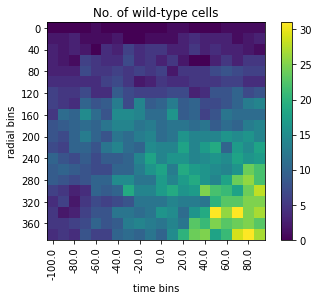

In [19]:
plt.xlabel("time bins")
plt.ylabel("radial bins")
plt.title('No. of wild-type cells')
#plt.ylim(10, num_radial_bins-0.5)
plt.yticks(ylocs, ylabels)
plt.xticks(xlocs, xlabels, rotation='vertical')
plt.imshow(num_wt)
plt.colorbar()
plt.savefig(os.path.join(root_path, 'Scr_17_num_wt.png'), bbox_inches = 'tight')

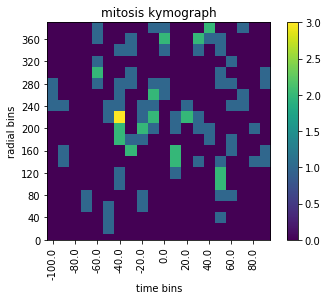

In [20]:
plt.title('mitosis kymograph')
plt.xlabel("time bins")
plt.ylabel("radial bins")
plt.ylim(0, num_radial_bins-0.5)
plt.yticks(ylocs, ylabels)
plt.xticks(xlocs, xlabels, rotation='vertical')
plt.imshow(num_wt_mito)
plt.colorbar()

/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


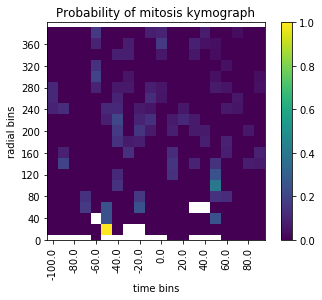

In [21]:
plt.title('Probability of mitosis kymograph')
plt.xlabel("time bins")
plt.ylabel("radial bins")
plt.ylim(0, num_radial_bins)
plt.yticks(ylocs, ylabels)
plt.xticks(xlocs, xlabels, rotation='vertical')
prob_mito = num_wt_mito / num_wt
plt.imshow(prob_mito)
plt.colorbar()

# re-running analysis script just over ROI above to see why it isnt finding cell 218

In [26]:
other_target_track

,ID,t,x,y,z,parent,root,state,generation,dummy
0,218,316,844.302734,968.789001,0.000000,53,1,3,2,False
1,218,317,853.391541,967.391541,0.000000,53,1,3,2,False
2,218,318,852.639526,962.968994,0.000000,53,1,3,2,False
3,218,319,854.486389,959.818726,0.000000,53,1,3,2,False
4,218,320,859.008911,957.430786,0.000000,53,1,0,2,False
5,218,321,863.816223,955.382996,0.000000,53,1,0,2,False
6,218,322,866.908142,954.312927,0.000000,53,1,0,2,False
7,218,323,870.252380,951.824463,0.000000,53,1,0,2,False
8,218,324,874.370850,949.020996,0.000000,53,1,0,2,False
9,218,325,876.738464,947.870728,0.000000,53,1,0,2,False


In [ ]:
## instead of going over all tracks, could go over all tracks that are definitely in_frame (using func) or in zone 
## set empty data variables to store 
## 2d arrays for counting gross occurences of wt or mito
num_wt_test, num_wt_mito_test = np.zeros((num_radial_bins, num_temporal_bins)), np.zeros((num_radial_bins, num_temporal_bins))
#max_N_wt = 100 ## upper limit to number of cells found in any bin
## 3d arrays for counting IDs of occurences for checking against raw data
#wt_IDs, wt_mito_IDs = np.zeros((num_radial_bins, num_temporal_bins, max_N_wt)), np.zeros((num_radial_bins, num_temporal_bins, max_N_wt))
## load one wt_track
#for j, wt_track in enumerate(tqdm(wt_tracks)):
wt_track = other_target_track
print("ID:", wt_track.ID)
## load first distance/radial bin
for n in range(num_radial_bins):
    #print("radial", range(int(radial_bin * n), int(radial_bin * (n+1))))
    ## load first temporal bin, over negative and positive range
    for l, m in enumerate(range(int(-num_temporal_bins/2), int(num_temporal_bins/2))): ## l introduced to iterate through pos integers for data storage
        #print("time",range(int(apop_time+temporal_bin*m),int(apop_time+temporal_bin*(m+1))))
        ## load first timepoint of wt_track
        for i in range(len(wt_track)): 
            ## calculate if within euclidean distance: if min of radial distance bin sqrd < (wt_track.x (at first time point) - target_track.x (at apop_time)) both squared + corresponding for yboth squared < max_dist squared
            if ((radial_bin * n)**2) < (wt_track.x[i] - target_track.x[apop_index])**2 + (wt_track.y[i] - target_track.y[apop_index])**2 < ((radial_bin * (n+1))**2):
                ## if FIRST time point is in temporal bin (centered around apop_time)
                if wt_track.t[i] in (range(int(apop_time+temporal_bin*m),int(apop_time+temporal_bin*(m+1)))):
                    num_wt_test[n,l] += 1 #str(wt_track.ID)
                    print("wt_track", wt_track.ID)
                    print("radial", range(int(radial_bin * n), int(radial_bin * (n+1))))
                    print("time",range(int(apop_time+temporal_bin*m),int(apop_time+temporal_bin*(m+1))))

                    ## storing ID in 3D ndarray
                    for p in range(len(wt_IDs[n,l,:])):
                        if wt_IDs[n,l,p] == 0:
                            wt_IDs[n,l,p] = wt_track.ID
                            break                        

                    #print("WT ID:", wt_track.ID, "time:", wt_track.t[i], "radial bin:", (n*radial_bin),"-", ((n+1)*radial_bin), "temporal bin:", (temporal_bin * m),"-", (temporal_bin * (m+1)),"i,m,n:", i,m,n)
                    if wt_track.fate.name == "DIVIDE" and "'METAPHASE', 'METAPHASE'," in str(wt_track.label[int(apop_time+(temporal_bin*m))-wt_track.t[0]:int(apop_time+(temporal_bin*(m+1)))-wt_track.t[0]]): ##explainer: this double condition states that if wt_track ends in mitosis but also has THREE (?) sequential metaphase classifications within the time window of that temporal bin then the condition is met
                        num_wt_mito[n,l] += 1 #str(wt_track.ID)
                        print("wt_track mitosis", wt_track.ID)
                        print("radial", range(int(radial_bin * n), int(radial_bin * (n+1))))
                        print("time",range(int(apop_time+temporal_bin*m),int(apop_time+temporal_bin*(m+1))))


                        ## storing ID in 3D ndarray
                        for p in range(len(wt_mito_IDs[n,l,:])):
                            if wt_mito_IDs[n,l,p] == 0:
                                wt_IDs[n,l,p] = wt_track.ID
                                break   


                        #print("MITO ID:", wt\_track.ID, "time:", wt_track.t[i], "radial bin:", (n*radial_bin),"-", ((n+1)*radial_bin), "temporal bin:", (temporal_bin * m),"-", (temporal_bin * (m+1)),"i,m,n:", i,m,n)
                    break ## if track is in bin, break loop iterating over all track positions to skip to next bin

    ##save out 4 different ndarrarys, 2 num and 2 IDs
    scr_ID_fn = 'Scr_'+str(target_track.ID)
    fn = os.path.join(root_path, 'analysis/raw_numbers/', scr_ID_fn)

    num_wt_fn = fn + '_num_wt'
    num_wt_mito_fn = fn + 'num_wt_mito'
    wt_IDs_fn = fn + 'wt_IDs'
    wt_mito_IDs_fn = fn + 'wt_mito_IDs'

    np.save(num_wt_fn, num_wt)
    np.save(num_wt_mito_fn, num_wt_mito)
    np.save(wt_IDs_fn, wt_IDs)
    np.save(wt_mito_IDs_fn, wt_mito_IDs)

### Launch napari to check against raw data 

In [ ]:
with napari.gui_qt():
    viewer = napari.Viewer()
    
    #viewer.add_image(bf)
    viewer.add_image(gfp, name="gfp", blending = "additive", colormap = "green")
    viewer.add_image(rfp, name="rfp", contrast_limits = (0, 50), blending = "additive", colormap = "red")
    
    viewer.add_tracks(wt_data)
    viewer.add_tracks(scr_data)
    
    plot_mitoses() ## utilises two functions above to plot apop and mito 
    plot_apoptosis()
    viewer.dims.set_point(0, (apop_time + delta_t)) ## open viewer at the timepoint of interest

# misc

In [ ]:
### checking how the tracker classifies state labels leading up to mitosis, seems the best classification is just a single metaphase but also double metaphase maybe more rigorous
count1 = 0
count2 = 0
for i, wt_track in enumerate(wt_tracks):
    if wt_track.fate.name == "DIVIDE":
        count1 += 1
        print(i,wt_track.ID, wt_track.label[-5:])
        if str(wt_track.label[-1:]) == "['METAPHASE']": #"['METAPHASE', 'METAPHASE']"
            count2 += 1
print("accuracy of classification above is", (count2/count1 *100))

distance binned but time not 

In [ ]:
t_range = range(-200,200)
wt_mito_ID_temporal_bins = {}

## create bins automatically
num_bins = 10
bin_size = radius / num_bins
## create dict for wt data storage
wt_track_bins = {}
wt_ID_bins = {} ## temp measure to create parallel dict just listing the IDs so that i can check algorithm works against raw data
wt_mitosis_bins = {}
wt_mito_ID_bins = {} ## temp measure to create parallel dict just listing the IDs so that i can check algorithm works against raw data

wt_tracks_in_radius = []
wt_mitosis_in_radius = []

for delta_t in t_range:
    ## creating temporal bin label
    temporal_bin_label = "frame" + str(find_apoptosis_time(target_track, index = False) + delta_t)
    wt_mito_ID_temporal_bins[temporal_bin_label] = {}
    radius = 500 ## maximum radius
    ## count all cells and mitoses within radius at delta_t
   
    wt_tracks_in_radius, wt_mitosis_in_radius = find_nearby_wt_mitosis(target_track, delta_t, radius)
    print("time", delta_t, "wt", len(wt_tracks_in_radius), "mito", len(wt_mitosis_in_radius))## currently returning zero hmmm
    ## iterate over all bins
    for i in range(num_bins):
        ## create bin label for dict entry 
        bin_label = str((bin_size * i)) + "< radial distance <" + str((bin_size * (i+1))) 
        ## create empty list to store each bins data in before storing
        wt_trackz = []
        wt_IDs = [] ## temp measure
        for wt_track in wt_tracks_in_radius:
            if (bin_size * i) <= euclidean_distance(target_track, wt_track, (find_apoptosis_time(target_track, index = False) + delta_t)) <= (bin_size*(i+1)):
                ## add track info to list for saving in dict bin entry
                wt_trackz.append(wt_track) 
                wt_IDs.append(wt_track.ID) ## temp measure
        ## add list of cells to dict entry
        wt_track_bins[bin_label] = wt_tracks
        wt_ID_bins[bin_label] = wt_IDs

        wt_mito_IDs = [] ## temp measure
        wt_mitos = []
        for wt_mito in wt_mitosis_in_radius:
            if (bin_size * i) <= euclidean_distance(target_track, wt_mito, (find_apoptosis_time(target_track, index = False) + delta_t)) <= (bin_size*(i+1)):
                ## add track info to list for saving in dict bin entry
                wt_mitos.append(wt_mito) 
                wt_mito_IDs.append(wt_mito.ID) ## temp measure
        ## add list of cells to dict entry
        wt_mitosis_bins[bin_label] = wt_mitos
        wt_mito_ID_bins[bin_label] = wt_mito_IDs
        #print(wt_mito_IDs, delta_t)
        
        #wt_mito_ID_temporal_bins[temporal_bin_label][bin_label] = wt_mito_IDs

In [ ]:
wt_mito_ID_temporal_bins

plotting wt_mito_ID_temporal_bins

In [ ]:
wt_mito_ID_temporal_bins['frame685']

In [ ]:
heatmap = np.zeros((10,400))

for i, key1 in enumerate(wt_mito_ID_temporal_bins.keys()):
    #print(i, key1)
    for j, key2 in enumerate(wt_mito_ID_temporal_bins['frame685'].keys()):
        #print(j,key2)
        if len(wt_mito_ID_temporal_bins[key1][key2]) > 4:
            print(key1, key2)
            print(len(wt_mito_ID_temporal_bins[key1][key2]))
        heatmap[j,i] = len(wt_mito_ID_temporal_bins[key1][key2])
#heatmap[:,0] = wt_mito_ID_temporal_bins[i][j]

In [ ]:
plt.imshow(heatmap, cmap= 'viridis', aspect = 'auto')#, #interpolation = 'nearest')
plt.colorbar()
plt.ylim(0,9)
#plt.xlim(0,10)
#plt.clim(0,3)
plt.title("Number of wild-type mitosis")
plt.text(195,-4.5, "Scr apoptosis -", rotation=90)
plt.xlabel("frame (unaligned)")
plt.ylabel("distance (50pixel bins)")
plt.savefig("/home/nathan/data/number_heatmap_Scr17.pdf", transparent=True, bbox_inches="tight", pad_inches=0.25, dpi = 300)
plt.show()